### Introduction to Probablistic Modelling  in Python Using PyMC3 
#### Notebook Author: Rhondene Wint


<h4> Objective </h4>

 In this notebook I :  

- 
 provided a basic explanation of Bayesian Inference with further really good reading resources
- 
 Implemented Markov Chain Monte Carlo (MCMC) using PyMC3 to find the weights of Bayesian Linear Regression model
- 
 Demonstrated how to evaluate MCMC performance with trace plots and autocorrelation



<h2> Why Probablistic Programming? </h2>  

A model describes data that could be observed from a system, given a set of assumptions. Uncertainty plays a fundamental role in modelling role since it is inherent in all data. Sources of uncertainty includes: 
- noise, 
- choosing the appropiate model given the data, and 
- the parameter values that define model which are used to predict new data.

A well-defined model is one that forecasts or make predictions about unobserved data having been trained on observed data. Probablity theory is the mathematical framework for modelling all forms of uncertainty. Bayesian probablistic models are used to quanitify uncertainty, and incorporate this information during forecasting. 

<p><h3> Components of Bayesian Probabilistic Models</h3></p>

<b> Key Point</b>: Instead of the conventional approach of learning single point estimates for the weights that define a model, bayesian models learn the distribution underlying the weights.    
The following are 3 the fundamental components to probablistic models:

- <b> Model Prior</b>: this is the probability distribution, <b>p(&Theta;)</b> that represents our beliefs or domain knowledge about the unobserved data before taking into consideration the observed data. 
- <b> Model Posterior</b>: This is the probability distribution, <b>p(&Theta;|X)</b> that represents the updated version of the prior after learning from the data (X). 
- <b> Likelihood</b>: this is the probability distribution, <b>p(X|&Theta;)</b> that represents the observed data. i.e. how we think the data is distributed

Therefore, probablistic models allows us to update our beliefs in light of the data. Supervised learning in Bayesian looks like this. <b>p(y|X,&Theta;)</b>, i.e. having seen X what can we say about y?

<h3> PyMC3 </h3>
<i>PyMc3 is python package for probablilistic modelling.  These examples are mostly from the originally published PyMC3 <a href= 'https://peerj.com/articles/cs-55/'>article</a> from Peer Journal Computer Science </i> 

-------------------------------------------------------------------------------------------------------------
<p></p>
<h4><i> Alert! If you have a basic machine learning background then I highly recommend reading Dr.Zoubin Ghahramani's excellent and easy to follow review on Probabilistic Machine Learning (Nature 2015), and his NIPS talk on said topic. I was desenstized by his presentations to finally start learning probabilistic machine learning</i></h4> 

<p></p>
My primary learning resources for theory are:

- <i>Machine Learning- A Probabilistic Perspective</i> by Kevin Murphy (e-book,effective so far),  
-  <i> Course Notes for Bayesian Models for Machine Learning</i> by John Paisley (Columbia University, google it)
-   <i>Information Theory, Inference and Learning Algorithms</i> by David Mackay (ebook, more intense deeper read but worthwhile so far)
------------------------------------------------------------------------------------------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats

##set seed for reproducibility of stochastic variables
np.random.seed(123)

### Bayesian Linear Regression 

Usually <b><t>y= &beta;<sub>0</sub>+&beta;<sub>1</sub>X2+&beta;<sub>2</sub>X2+&epsilon; </t></b>
, where y is the response variable, X is an independent variable &beta; are the coefficients of the model which represents the estimates of the population parameters and finally &epsilon; is the random error term.

However in Bayesian:
We want to predict the outcomes Y as normally distributed observations with an expected value of &mu;, which is linear function of &beta; and X
<b> Y ~ &Nu;(&mu;,&sigma;) </b>, where each parameter is also normally distributted.
&mu;=&beta;<sub>0</sub>+&beta;<sub>1</sub>X2+&beta;<sub>2</sub>X2


In [6]:
#t set rue parameter values
alpha,sigma=1,1
beta = [1,2.5]
#size of datasets
size=100
#predictor variables
x1 = np.linspace(0,1,size)
x2 = np.linspace(0,2,size)
#simulate values of outcome variable
Y= alpha+beta[0]*x1+beta[1]*x2+np.random.randn(size)*sigma

In [10]:
from pymc3 import Model, Normal, HalfNormal 
#half-normal restricts the normal dist to positive values

#instanitiate the model
basic_model = Model() 
#Model specification 
with basic_model:  
    
    #Priors for the unkown model parameters
    """We will apply zero-mean normal priors with variance of 10 to both regression coefficients, 
    which corresponds to weak information regarding the true parameter values"""
    
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma= HalfNormal('sigma', sd=1)
    
    #expected value of response variable
    mu = alpha+beta[0]*x1+beta[1]*x2
    
    #likelihood (sampling distribution of observations)
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [11]:
## estimate the posterior for the unkown variables
from pymc3 import find_MAP

"""Maximum a posteriori MAP is used to find point estimates from the posterior distibution"""

##model fitting
map_estimate = find_MAP(model=basic_model)
print(map_estimate)
    

/home/alchemiss/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -164.52, ||grad|| = 0.0015524: 100%|██████████| 23/23 [00:00<00:00, 120.81it/s] 


{'alpha': array(1.01346457), 'beta': array([1.20540687, 2.41081374]), 'sigma_log__': array(0.1143869), 'sigma': array(1.12118583)}


Comment: As we can see the MAP estimates of parameter values are very close to the true parameter values

## Sampling Methods for Estimating Posterior Distribution

MAP can be sub-optimal for extreme or messy real-world models, so we use more robust techniques such simulation based sampling methods like <b>Markov Chain Monte Carlo</b> algorithms that can generate samples from the posterior distribution. There are several different implementations of the MCMC algorithm, for example, Hamiltoninan, Metropolis, NUTS, Slice etc.

Simulation based algorithms are necessary because for many real-world high-dimensioanl data we cannot analytically compute the posterior distribution according to Bayes' Theorem.

<h4> Metropolis-Hastings Markov Chain</h4> 

Metropolis-Hastings Markov chain samples from a generic probability distribution (<i> target distribution</i>) by constructing a Markov Chain such that the stationary distribution is the target distribution. In this case, the target distribution is the posterior distribution of the unknown model parameters that we want to estimate.

<h4> from Thomas Wiecki's blog <a href='http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/ '>post</a> on MCMC </h4>
<i> The basic idea is to sample from the posterior distribution by combining a "random search" (the Monte Carlo aspect) with a mechanism for intelligently "jumping" around, but in a manner that ultimately doesn't depend on where we started from (the Markov Chain aspect). Hence Markov Chain Monte Carlo methods are memoryless searches performed with intelligent jumps.</i>


<b> N.B.</b>: Prof. Matthew Heiner (UC Santa Cruz) gives an intuitive breakdown of the MCMC in his <i>Bayesian Statistics: Techniques and Models</i> course that you can audit for free on Coursera. 


### Implement Metropolis-Hastings sampler to sample 2000 draws from the posterior

In [23]:
from pymc3 import NUTS, sample
from scipy import optimize

with basic_model:
    #initialise starting values with MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    ##initialise sampleer
    step = pm.Metropolis()
    #draw 2000 posterior samples
    trace_MH = sample(2000,step,start=start)

/home/alchemiss/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/alchemiss/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:102: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -164.95:   8%|▊         | 396/5000 [00:00<00:02, 1910.30it/s]


Optimization terminated successfully.
         Current function value: 164.709367
         Iterations: 9
         Function evaluations: 396


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:01<00:00, 2902.49draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Use NUTS to sample 2000 draws from the posterior 

PyMC3’s most capable MCMC method is the No-U-Turn Sampler. NUTS is especially useful for sampling from models that have many continuous parameters, a situation where older MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density.

In [24]:
from pymc3 import NUTS, sample
from scipy import optimize

with basic_model:
    #initialise starting values with MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    #instantiate sampler
    step = NUTS(scaling=start)
    #draw 2000 posterior samples
    trace_nuts = sample(2000,step,start=start)
    

/home/alchemiss/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/alchemiss/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:102: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -164.95:   8%|▊         | 396/5000 [00:00<00:02, 2007.01it/s]


Optimization terminated successfully.
         Current function value: 164.709367
         Iterations: 9
         Function evaluations: 396


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:30<00:00, 162.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


## Assessing MCMC Performance

Recall that MCMC algorithms are using simulated Markov chains to find a stationary distribution that we use to sample the parameter posterior estimates. How can we assess if the Markov Chains are converging on the stationary distribution?

These two widely used techniques will be used to compare the Metropolis-Hastings versus the NUTS implementation of MCMC:

1. Trace Plots
2. Autocorrelation Plots


### 1. Trace Plots for Assessing MCMC Performance


The <b>trace</b> object stores the history of the Markov Chain for estimated parameter values along each iteration. A trace plot shows where the chains have been exploring. Positive signs of convergence are:
- The average value for the chain, should be roughly flat -  the iterations oscillate around a specific value. 
- And it should not be lingering at any one value for too many iterations -  we want to avoid flatlines

In [25]:
trace_MH['alpha'][-5:]

array([1.06813594, 1.06813594, 1.06813594, 1.06813594, 1.06813594])

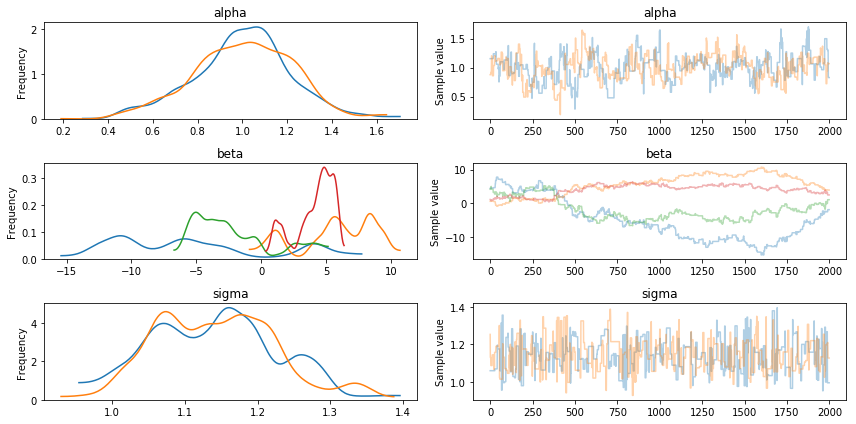

In [26]:
## Trace Plot of the Metropolis-Hastings Sampler
from pymc3 import traceplot

traceplot(trace_MH)
plt.show()

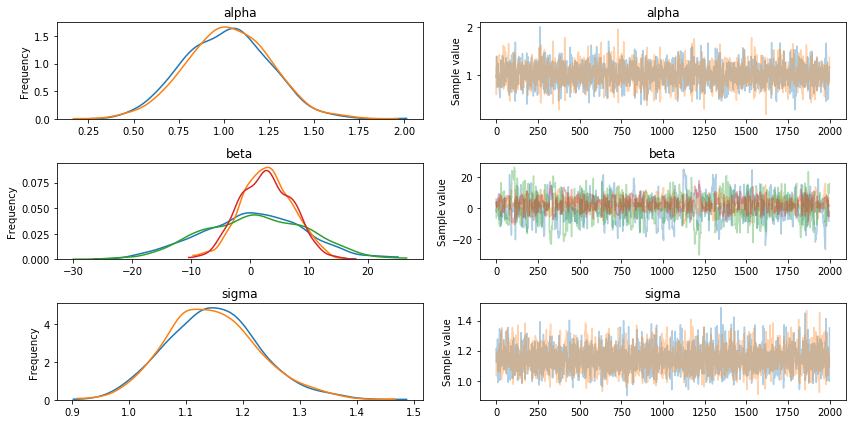

In [27]:
## Trace Plot of the no U-Turn Sampler
traceplot(trace_nuts)
plt.show()

### 2. Autocorrelation Analysis

<b> Autocorrelation </b> is a value between -1 and +1 that measures the linear dependence between the current value of the chain and the past value of the chain (referred to as lags).  Autocorrelation is a major componenent of MCMC analysis because it tells us how much information is in the Markov Chain.   


A good sign of convergence is if autocorrelation becomes smaller as k-lags increases, that is, the samples can be considered independently distributed. Highly correlated Markov chains are less informative that independent Markov Chains.

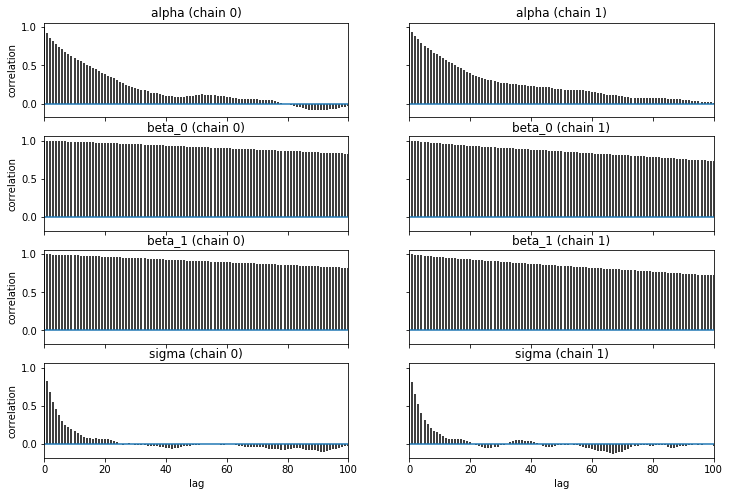

In [28]:
##Autocorrelation for Metropolis-Hastings 
pm.plots.autocorrplot(trace_MH)
plt.show()

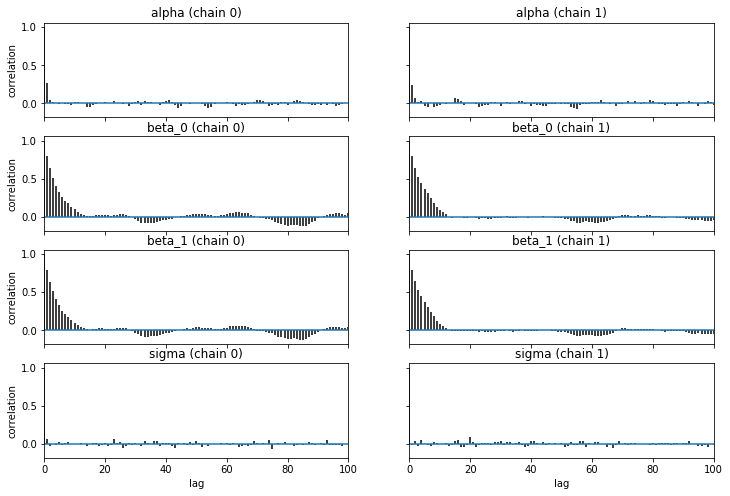

In [29]:
##Autocorrelation for NUTS  
pm.plots.autocorrplot(trace_nuts)
plt.show()

<h3> Conclusion:</h3>  
Clearly the traceplots and autocorrelation plots agree that the NUTS provides much better convergence that the Metropolis-Hastings implementation of MCMC.